In [1]:
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
import numpy as np
import math
from scipy import signal
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

cmap = cm.get_cmap("plasma_r")


In [25]:
def Butterworth_Low(Signal,CutoffFrequency = 10 ,SamplingFrequency = 200):
    NormFrequency = CutoffFrequency / (SamplingFrequency / 2.0)
    
    b,a = signal.butter(1, NormFrequency, "low")
    output =  signal.filtfilt(b, a, np.asarray(Signal)).tolist()
    return output


def CalculateKostrovSolution(Time,Stress,mu, v,r):
    result = (24/(7*np.pi))*(Stress/mu)*np.sqrt((v**2)*(Time**2)-r**2)
    if math.isnan(result):
        return 0.0
    else:
        return result

In [26]:
def PlotBimatReference(ax, path, SlipSlipRate):
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    for NumStat in range(1,5):
        Station = pd.read_csv(path + "Bimat/pcsi_SSC.obs{}".format(NumStat), delimiter=r"\s+",header=None,
                             names=["time (s)" , "slip rate (m/s)", "slip (m)", "shear stress (Pa)", "normal stress (Pa)","strength (Pa)"])
        
        ax.plot(Station["time (s)"],Butterworth_Low(Station[FileNameDict[SlipSlipRate]]), c = "b", ls= ":")
    ax.set_xlabel("time (s)")
    ax.set_ylabel(FileNameDict[SlipSlipRate])


def PlotSem2dpackReference(ax, path, SlipSlipRate):
    FileNameDict = {"Slip" : "slip", "SlipRate" : "sr", "Shear":"sxy"}
    ListReference = sorted(glob(path+"sem2dpack/sem2d-{}-*.txt".format(FileNameDict[SlipSlipRate])))
    
    for idx, item in enumerate(ListReference):
        line = pd.read_csv(item,header=None)
        
        if SlipSlipRate=="Shear":
            line[1] = line[1]*10e5
        ax.plot(line[0],Butterworth_Low(line[1]), label = "", c = "k",ls = "-")
        
    ax.set_xlabel("time (s)")
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    ax.set_ylabel(FileNameDict[SlipSlipRate])
    
def PlotHandPickedReference(ax, path, SlipSlipRate):
    ListReference = sorted(glob(path + "HandPicking/{}/".format(SlipSlipRate)+"*.csv"))

    for idx, item in enumerate(ListReference):
        line = pd.read_csv(item)
        ax.plot(line["X"],line["Y"],c = "r", label = "", ls = "-", zorder=1)
        
    ax.set_xlabel("time (s)")
    FileNameDict = {"Slip" : "slip (m)", "SlipRate" : "slip rate (m/s)", "Shear":"shear stress (Pa)"}
    ax.set_ylabel(FileNameDict[SlipSlipRate])    
    
def PlotReference(ax,SlipSlipRate):
    Stress = 10.0e6 
    ElasticShearModulus = 13.333e9
    Velocity = 2.0e3
    
    TimeList = np.arange(0, 5, 0.01).tolist()
    
    if SlipSlipRate=="Slip":
        for r in [0,2000,4000,6000,8000]:
            Slip = [CalculateKostrovSolution(Time,Stress,ElasticShearModulus, Velocity, r) for Time in TimeList]
            ax.plot(TimeList,Slip,ls="-",c="k", lw=1, zorder=1)
    elif SlipSlipRate=="SlipRate":
        for r in [0,2000,4000,6000,8000]:
            Slip = [CalculateKostrovSolution(Time,Stress,ElasticShearModulus, Velocity, r) for Time in TimeList]
            SlipRate = np.gradient(Slip, TimeList[1]-TimeList[0],edge_order=2) 
            ax.plot(TimeList, SlipRate, ls = "-", c = "k", lw = 1, zorder=1)

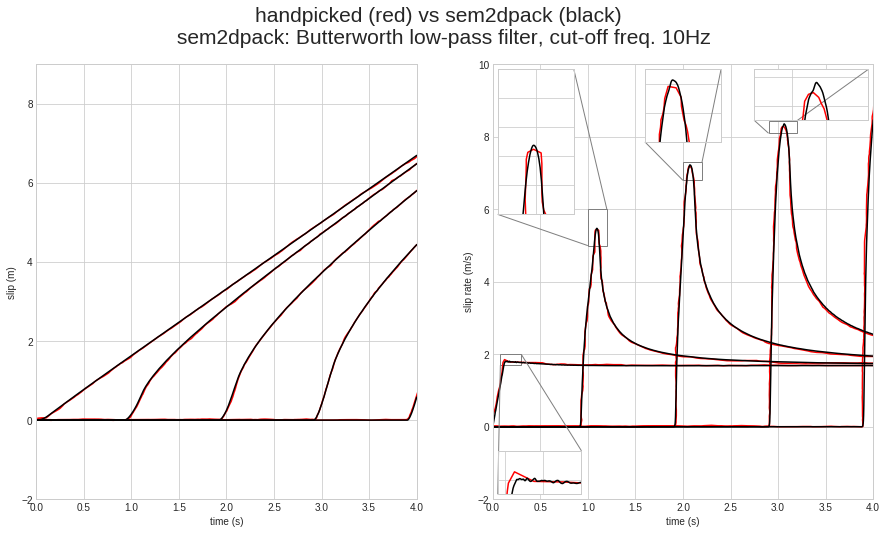

In [27]:
path="/home/nico/Documents/TEAR/Codes_TEAR/ProfilePicking/Output/Reference/"

fig = plt.figure(figsize = (15,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
#ax3 = fig.add_subplot(2,2,3)
        

ax1.set_xlim([0,4])
ax1.set_ylim([-2,9])
ax2.set_xlim([0,4])
ax2.set_ylim([-2,10])
#ax3.set_xlim([0,4])
    
    
fig.suptitle('handpicked (red) vs sem2dpack (black) \n sem2dpack: Butterworth low-pass filter, cut-off freq. 10Hz', fontsize=21)

#PlotBimatReference(ax1, path, "Slip"); PlotBimatReference(ax2,path, "SlipRate"); PlotBimatReference(ax3,path, "Shear")


PlotSem2dpackReference(ax1,path,"Slip"); PlotSem2dpackReference(ax2,path,"SlipRate"); #PlotSem2dpackReference(ax3,path,"Shear")

PlotHandPickedReference(ax1,path,"Slip"); PlotHandPickedReference(ax2,path,"SlipRate");# PlotHandPickedReference(ax3,path,"Shear")

#PlotReference(ax1,"Slip"); PlotReference(ax2,"SlipRate"); PlotReference(ax3,"Shear")


def DrawInlet(location, ax, SlipSlipRate, loc):
    axins = zoomed_inset_axes(ax,4,loc=loc)
    x1, x2, y1, y2 = location


    PlotSem2dpackReference(axins,path,SlipSlipRate); PlotHandPickedReference(axins,path,SlipSlipRate)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.tick_params(axis='both', which='both',left=False, bottom=False, labelbottom=False, labelleft=False)
    axins.set_xlabel("")
    axins.set_ylabel("")

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
    
    

DrawInlet([1, 1.2, 5, 6], ax2, "SlipRate",2)
DrawInlet([2, 2.2, 6.8, 7.3], ax2, "SlipRate",9)
DrawInlet([2.9, 3.2, 8.1, 8.45], ax2, "SlipRate",1)
DrawInlet([.08, 0.3, 1.7, 2], ax2, "SlipRate",3)